In [20]:
# Cell 1: Imports
# ----------------
# Bring in the pieces we need to load data, split, scale, build models, and evaluate.
# Keep imports at top so notebook is easy to read and reproducible.

from sklearn.datasets import fetch_california_housing   # built-in regression dataset
from sklearn.model_selection import train_test_split    # to split into train/test
from sklearn.preprocessing import StandardScaler        # to normalize features

# Optional extras used later for metrics & plotting
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [21]:
# Cell 2: Load dataset, split, and scale
# -------------------------------------
# This cell handles preprocessing:
#  - load the California housing dataset
#  - do a train/test split (avoid peeking at test data)
#  - fit the scaler on training features only, then transform both train and test
# Note: We scale features because many regressors (KNN, SVR, regularized linear models)
# depend on feature scale. Tree models don't strictly need scaling, but it's fine.

# Load data
X, y = fetch_california_housing(return_X_y=True)
# X.shape -> (n_samples, n_features), here n_features = 8
# y is continuous: median house value (units in dataset docs)

# Split (80% train / 20% test). Add random_state for reproducibility if desired.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create scaler and apply it correctly:
scaler = StandardScaler()
# Fit scaler *only on training data* to avoid data leakage
X_train_scaled = scaler.fit_transform(X_train)
# Use the same transform on test data (do NOT call fit_transform on test)
X_test_scaled = scaler.transform(X_test)

In [22]:
# Cell 3: Import regressors and train a model
# -------------------------------------------
# We'll show a baseline LinearRegression model here.
# You can swap `LinearRegression()` with other regressors easily.
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Choose a regressor (baseline)
reg = LinearRegression()

# Train (fit) on the scaled training data
# For LinearRegression this computes coefficients that minimize squared error
reg.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


R² (built-in .score): 0.575787706032451
MSE: 0.5559, RMSE: 0.7456, MAE: 0.5332
R² (r2_score): 0.575787706032451


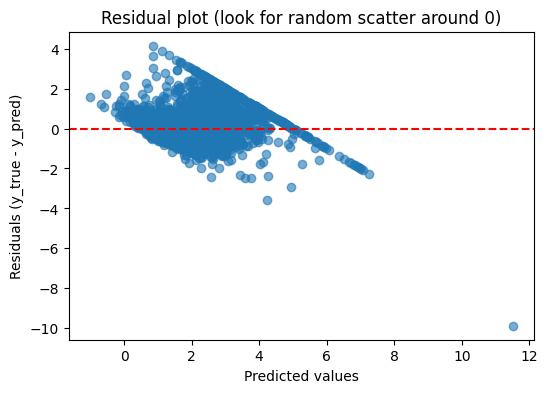

In [23]:
# Cell 4: Evaluation - R² (.score), plus MSE/MAE/RMSE and residual diagnostics
# ----------------------------------------------------------------------------
# Important: For scikit-learn regressors, reg.score(X, y) returns R² (coefficient
# of determination). See full explanation below.

# 1) Quick built-in R² using .score()
r2_builtin = reg.score(X_test_scaled, y_test)
print("R² (built-in .score):", r2_builtin)

# 2) Compute prediction & classic regression metrics explicitly
y_pred = reg.predict(X_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# 3) Compute R² explicitly (same formula as r2_score)
r2_manual = r2_score(y_test, y_pred)
print("R² (r2_score):", r2_manual)

# 4) Residuals (useful for diagnosing bias / heteroscedasticity / outliers)
residuals = y_test - y_pred

# 5) Quick residual plot to check error distribution
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals (y_true - y_pred)")
plt.title("Residual plot (look for random scatter around 0)")
plt.show()

# ---------------------------
# R² Explanation (detailed, bro)
# ---------------------------
# R² (coefficient of determination) measures how much of the target variance
# is explained by the model. It is computed as:
#
#    R2 = 1 - (SS_res / SS_tot)
#
# where:
#    SS_res = sum( (y_i - y_pred_i)^2 )        <-- residual sum of squares (error)
#    SS_tot = sum( (y_i - y_mean)^2 )         <-- total sum of squares (variance of y)
#
# In code form:
#    y_mean = np.mean(y_test)
#    SS_res = np.sum((y_test - y_pred)**2)
#    SS_tot = np.sum((y_test - y_mean)**2)
#    R2 = 1 - SS_res / SS_tot
#
# Interpretation:
#  - R² = 1.0  => perfect predictions (no residual error)
#  - R² = 0.0  => model does no better than predicting the mean y_mean
#  - R² < 0.0  => model is worse than predicting the mean (bad; underfitting or wrong model)
#
# Important notes / caveats:
#  - R² alone doesn't tell full story: pair with RMSE/MAE and residual plots.
#  - R² is sensitive to outliers (a few big errors hurt SS_res a lot).
#  - R² is not directly comparable between datasets with different target variances.
#  - For skewed errors, use MAE or median-based metrics too.
#
# Practical recommendation:
#  - Report R² AND RMSE (or MAE). Use residual plots to check non-random patterns.
#  - For model selection, prefer cross-validated R² or cross-validated RMSE.

In [24]:
# Cell 5: Single test instance (inspect shape & features)
# -------------------------------------------------------
# Grab one sample from the scaled test set. This is a 1D vector of length = n_features.
single_instance = X_test_scaled[0]
print("single_instance shape (1D):", single_instance.shape)  # e.g., (8,)
# single_instance is 1D -> shape (n_features,)
# To use with scikit-learn predict(), we need a 2D row: shape (1, n_features)

single_instance shape (1D): (8,)


In [25]:
# Cell 6: Predict for a single instance
# ------------------------------------
# scikit-learn expects 2D inputs: (n_samples, n_features).
# For a single sample we reshape to (1, -1) or wrap in a list: [single_instance]
#   - reshape(1, -1): 1 = one row (sample), -1 = infer number of columns (features)
# Example:
pred_single = reg.predict(single_instance.reshape(1, -1))  # shape (1,) -> array with one value
print("Predicted value for sample #0:", pred_single[0])

# or equivalently:
pred_single_alt = reg.predict([single_instance])  # also works

Predicted value for sample #0: 0.7191228416019151


In [26]:
# Cross-validated R² (better for model selection)
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

pipe = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))
cv_scores = cross_val_score(pipe, X, y, cv=5, scoring='r2')
print("5-fold CV R² mean:", np.mean(cv_scores))

# Save model to disk for later use
import joblib
joblib.dump(reg, "linear_regression_model.joblib")
# To load later: model = joblib.load("linear_regression_model.joblib")


5-fold CV R² mean: 0.6559022792657999


['linear_regression_model.joblib']

In [ ]:
# 🧾 REGRESSION vs CLASSIFICATION
# ---------------------------------
# Regression → Predicts CONTINUOUS values (e.g. house price, temperature)
#   - Target y: real numbers
#   - Evaluation: R², MSE, MAE, RMSE
#   - Example model: LinearRegression, SVR, RandomForestRegressor
#
# Classification → Predicts CATEGORIES / classes (e.g. spam vs ham, malignant vs benign)
#   - Target y: discrete labels (0/1, "cat"/"dog")
#   - Evaluation: Accuracy, Precision, Recall, F1-score, Confusion Matrix
#   - Example model: LogisticRegression, SVC, RandomForestClassifier